# Reproduce DL
## Automated Pavement Crack Segmentation

We start by setting up the actual Architecture. This means making sure all weights are properly initialized and all layers are connected. 

We make use of PyTorch for the implementation.

Multiple parts come together (A U-based ResNet);
- We recreate ResNet34 and remove the last two layers
- We made sure that a ResNet-block is either 4 or 6 layers depending on if stride is not 1 (which in our case always happens when the in_channels are not equal to out_channels)
- We use transfer learning such that the ResNet34 parameters are initialized as if trained on ImageNet
- We create Squeeze and Excitation blocks that are applied per Channel (cSE) and per Spatial (sSE) (image)
- These two blocks are combined (scSE) and then the maximum of this is taken
- Each convolutional layer its parameters are initialized via "He Kaiming" method.

In [ ]:
# Do all the imports
## Packages
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm
from torchsummary import summary
import torch
import os

## Project
from architecture import main
from datasets.CFD.CFDdata import CFD
from datasets.CRACK500.CRACKdata import C5D
from loss.loss import batch_dice_loss
from utils.layers import layer_split
from utils.retrieve_device import try_gpu

In [11]:
# Summarize the Architecture as output
network = main.Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = network.to(device)

# print(network)
summary(model, input_size=(3, 320, 480))

The current dataset is size:  118 
The current split is train/test:  71 / 47


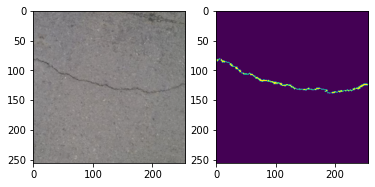

In [6]:
# Load and transform the data in batches train & test
current_path = os.path.abspath(os.getcwd())

resize_image = (256, 384)
crop_image = 256

shared_transforms = [
    transforms.RandomCrop(crop_image),
    transforms.Pad(200, padding_mode='reflect'),
    transforms.RandomRotation((0,360)),
    transforms.CenterCrop(crop_image),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
]
# Bilinear interpolation since value can be [-255, +255]
tf_compos = transforms.Compose([
    transforms.Resize(resize_image, interpolation=InterpolationMode.BILINEAR),
    *shared_transforms, 
    transforms.ColorJitter(brightness=0.05, contrast=0.05), 
    transforms.ToTensor()
    ])
# NN interpolation since value can only be [0 or 1]
tf_compos_gt = transforms.Compose([
    transforms.Resize(resize_image, interpolation=InterpolationMode.NEAREST),
    *shared_transforms, 
    transforms.ToTensor()
    ])

dataset = CFD(current_path + "/datasets/CFD/cfd_image/", tf_compos, current_path + "/datasets/CFD/seg_gt/", tf_compos_gt)

train_data, test_data = random_split(dataset, [71, 47])
train_loader = DataLoader(train_data, batch_size=10)
test_loader = DataLoader(test_data, batch_size=47)

## Dataloader debugging
print("The current dataset is size: ", len(dataset), 
"\nThe current split is train/test: ", len(train_loader.dataset), "/", len(test_loader.dataset))
# ----------------------------
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import torchvision

import traceback
try:
    image, label = dataset[6]
except Exception:
    traceback.print_exc()

image = transforms.ToPILImage()(image)
label = transforms.ToPILImage()(label)

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(image)
axarr[1].imshow(label)
# # ----------------------------

In [18]:
def get_prec_recall(data_loader, network, device=torch.device("cpu")):
    network.eval()
    isect_sum = torch.tensor([0], dtype=torch.float32, device=device)
    positive_predicts_pixels = 0
    positive_truth_pixels = 0

    for X, y in data_loader:
        # Copy the data to device.
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            batch_size = y.shape[0]
            y = y.long()
            pred = (network(X) >= 0.5).long()
            isect_sum += torch.sum(torch.logical_and(y, pred))
            positive_predicts_pixels += torch.sum(pred)
            positive_truth_pixels += torch.sum(y)

    precision = isect_sum / positive_predicts_pixels
    recall = isect_sum / positive_truth_pixels
    return (precision.item(), recall.item())


def get_f1(precision, recall):
    return 2*precision*recall / (precision+recall)


def epoch_to_PIL(data_loader, network, device=torch.device("cpu")) -> dict:
    converted = {"xs": [], "ys": [], "preds": []}
    for x_batch, y_batch in data_loader:
        preds = network(x_batch)
        converted["xs"].extend(batch_to_PIL(x_batch))
        converted["ys"].extend(batch_to_PIL(y_batch))
        converted["preds"].extend(batch_to_PIL(preds))
    return converted


def batch_to_PIL(tensor_batch) -> list:
    converted = []
    for t in tensor_batch:
        img = transforms.ToPILImage()(t)
        converted.append(img)
    return converted

In [10]:
# Set up simple loop on GPU, one epoch

from architecture import main
from loss.loss import batch_dice_loss
from utils.layers import layer_split
from utils.retrieve_device import try_gpu
import torch
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm


# training parameters
lr = 1e-3

epochs = 10

# Define list to store losses and performances of each interation
images = []
labels = []
predictions = []

# Try using gpu
device = torch.device('cuda:0')

#Initialize network
network = main.Net()

#Initiliaze loss function
criterion = batch_dice_loss

optimizer = torch.optim.AdamW(network.parameters(), lr=lr, betas=(0.9, 0.999))


for epoch in tqdm(range(epochs)):

    # Network in training mode and to device
    network.train()
    network.to(device)

    # Training loop
    for i, (x_batch, y_batch) in enumerate(train_loader):

        # Set to same device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Set the gradients to zero
        optimizer.zero_grad()

        # Perform forward pass
        y_pred = network(x_batch)

        # Compute the loss
        loss = criterion(y_pred, y_batch)
        train_losses.append(loss)

        # Backward computation and update
        loss.backward()
        optimizer.step()
    
    # Compute precision, recall, and f1 for train and test data
    train_prec, train_recall = get_prec_recall(train_loader, network.to("cpu"))
    train_f1 = get_f1(train_prec, train_recall)
    test_prec, test_recall = get_prec_recall(test_loader, network.to("cpu"))
    test_f1 = get_f1(test_prec, test_recall)

    # Print performance
    print('Epoch: {:.0f}'.format(epoch+1))
    print(f'Precision, Recall, and F1 of train set: {train_prec}, {train_recall}, {train_f1}')
    print(f'Precision, Recall, and F1 of test set: {test_prec}, {test_recall}, {test_f1}')
    print('')

# Save model
model_state = network.state_dict()
torch.save(model_state, "model_parameters_gpu.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
# Elaborate loop of multiple Epoch
from architecture import main
from loss.loss import batch_dice_loss
from utils.layers import layer_split
from utils.retrieve_device import try_gpu
import torch

# training parameters
lr = 1e-3

# Always needs to be a factor of 3
# Phase 1 = 1/3 time, Phase 2 = 2/3 time
EPOCHS = 12
epochs_1 = ( EPOCHS // 3 )
epochs_2 = ( EPOCHS // 3 ) * 2

# Init appropriately
# ---

# ---

# Split layers into three, for seperate optimization
layer_1, layer_2, layer_3 = layer_split(network)

optimizer = torch.optim.AdamW([
    {'params': layer_1, 'lr': 0},
    {'params': layer_2, 'lr': lr/3},
    {'params': layer_3, 'lr': lr}], betas=(0.9, 0.999))

for epoch in range(epochs_1):

    # Init appropriately
    # ---

    # ---

optimizer = torch.optim.AdamW([
    {'params': layer_1, 'lr': lr/9},
    {'params': layer_2, 'lr': lr/3},
    {'params': layer_3, 'lr': lr}], betas=(0.9, 0.999))

for epoch in range(epochs_2):

    # Init appropriately
    # ---

    # ---

KeyboardInterrupt: 

In [ ]:
# from torchviz import make_dot

# x = torch.randn(1,3, 320, 480)
# y = net(x) 

# make_dot(y).view()

In [19]:
pics = epoch_to_PIL(test_loader, network)

#subplot(r,c) provide the no. of rows and columns
n_examples = 10
f, axarr = plt.subplots(n_examples,3, figsize=(15, n_examples*4)) 

for i in range(n_examples):
    axarr[i][0].imshow(pics["xs"][i])
    axarr[i][1].imshow(pics["ys"][i])
    axarr[i][2].imshow(pics["preds"][i])


KeyboardInterrupt: 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=411d58e9-cb4b-4924-bef0-2f383eff0187' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>